In [1]:
import os
import shutil
import sys
import time
from PIL import Image
from datetime import date, datetime, timedelta


sys.path.insert(0, '..')
from utils import mongodb

In [2]:
from pesagensbalanca import cursor_pesagensbalanca, extract_to

### Generate pesagens database
Necessário acesso ao Banco de Dados ou ao Servidor

In [3]:
start = datetime(2020, 3, 1)
end = datetime.today()
limit = 10
s0 = time.time()
# cursor = cursor_pesagensbalanca(mongodb, start, end, limit, crop=True)
# count = extract_to(cursor, crop=True)
s1 = time.time()
# print('{:0.2f} segundos para processar {:d} registros'.format((s1 - s0), count))


## Carregar e montar modelo

In [4]:
import pandas as pd
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

from model01 import model

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 144, 288, 16)      1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 72, 72, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 72, 72, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        1

In [6]:
model.load_weights('gerabasesvazios_cropped_tunned.hdf5')


In [7]:
x = layers.Dense(256, use_bias=False)(model.get_layer('flatten').output)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(1, activation='linear')(x)
x = layers.Dense(256, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(1, activation='linear')(x)
regression_model = models.Model(inputs=model.input, outputs=x)
#for layer in regression_model.layers[:-3]:
#    layer.trainable = False
regression_model.compile(loss='mae', optimizer='adam')


In [8]:
regression_model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 144, 288, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 144, 288, 16)      1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 72, 72, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 72, 72, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 32)        0     

In [9]:
for layer in regression_model.layers:
    print(layer, layer.trainable)


<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f7727462ba8> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f77a9b8b898> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f772744f1d0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f772744f3c8> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f772744f518> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f772744f978> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f772744fb70> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f772744fc88> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f772745a128> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f772745a320> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f772745a438> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f772745a898> True
<tensorflow.py

## Carregar e montar dados para treinamento

In [10]:
df = pd.read_csv('../../bases/pesagensbalanca/pesos.txt')
df['dif'] = abs(df['pesobalanca'] - df['pesodeclarado'])
df['filename'] = df['id'].map('{}.jpg'.format)
df.head()

,id,pesobalanca,pesodeclarado,dif,filename
0,5e5d096a3d0ec8337863f799,7170,7167,3,5e5d096a3d0ec8337863f799.jpg
1,5e5d09703d0ec8337863f9ee,29190,29149,41,5e5d09703d0ec8337863f9ee.jpg
2,5e5d09703d0ec8337863f9f2,6380,6348,32,5e5d09703d0ec8337863f9f2.jpg
3,5e5d099986556b3036c6dc6d,7610,7788,178,5e5d099986556b3036c6dc6d.jpg
4,5e5d094386556b3036c6dc5c,22280,22300,20,5e5d094386556b3036c6dc5c.jpg


In [11]:
df.describe()

,pesobalanca,pesodeclarado,dif
count,9317.000000,9317.000000,9317.000000
mean,18572.832027,18807.056349,1162.008801
std,8261.590188,8106.655375,3793.829146
min,0.000000,2070.000000,0.000000
25%,11300.000000,11453.000000,72.000000
50%,19600.000000,19960.000000,175.000000
75%,25270.000000,25575.000000,446.000000
max,113350.000000,41388.000000,94730.000000


In [12]:
df[df['dif'] < 4000]['dif'].count() # Pegar somente os pesos que batem declarado x balança

8734

In [13]:
df[df['dif'] < 1000]['dif'].count() # Pegar somente os pesos que batem declarado x balança

8104

In [14]:
df_filtered = df[df['dif'] < 1000]
splitmask = np.random.rand(len(df_filtered)) < 0.9
df_train = df_filtered[splitmask]
df_val = df_filtered[~splitmask]

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory='../../bases/pesagensbalanca/pesagensbalanca_cropped',
    target_size=(144, 288),
    batch_size=64,
    x_col='filename',
    y_col="pesobalanca",
    shuffle=False,
    class_mode='other' 
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=df_val,
    directory='../../bases/pesagensbalanca/pesagensbalanca_cropped',
    target_size=(144, 288),
    batch_size=64,
    x_col='filename',
    y_col="pesobalanca",
    shuffle=False,
    class_mode='other' 
)

Found 7305 validated image filenames.
Found 799 validated image filenames.


## Train 

In [16]:
regression_model.compile(optimizer=optimizers.Adam(lr=0.001),
                         loss='mean_squared_error', metrics=['mse', 'mae'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4,
                          verbose=1, min_delta=1e-2, mode='min')

In [17]:
regression_model.fit(train_generator, epochs=50,
                     callbacks=[reduce_lr],
                   validation_data = val_generator,
                   validation_steps = val_generator.samples // 64)

Train for 115 steps, validate for 12 steps
Epoch 1/50
115/115 [==============================] - 74s 646ms/step - loss: 415220087.1618 - mse: 415317120.0000 - mae: 18748.2188 - val_loss: 411975074.6667 - val_mse: 411975136.0000 - val_mae: 18732.5156
Epoch 2/50
115/115 [==============================] - 78s 679ms/step - loss: 413269757.3120 - mse: 413364256.0000 - mae: 18707.0645 - val_loss: 411204725.3333 - val_mse: 411204704.0000 - val_mae: 18717.6133
Epoch 3/50
115/115 [==============================] - 79s 687ms/step - loss: 410647039.1654 - mse: 410747680.0000 - mae: 18652.5430 - val_loss: 410009160.0000 - val_mse: 410009184.0000 - val_mae: 18692.5410
Epoch 4/50
115/115 [==============================] - 76s 665ms/step - loss: 407398051.1860 - mse: 407481120.0000 - mae: 18582.9707 - val_loss: 404288392.0000 - val_mse: 404288352.0000 - val_mae: 18568.2539
Epoch 5/50
115/115 [==============================] - 79s 683ms/step - loss: 403518297.2356 - mse: 403595264.0000 - mae: 18499.69

W0402 10:49:07.115427 140152601270016 callbacks.py:1824] Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: lr


  1/115 [..............................] - ETA: 1:57:27

KeyboardInterrupt: 

In [ ]:
model.save_weights('gerabasespesagens_cropped.hdf5')

4575.0156 27900


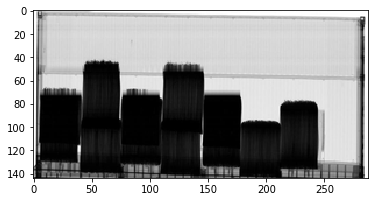

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt
sample = df.sample()
filename = sample['filename'].item()
image = Image.open('../../bases/pesagensbalanca/pesagensbalanca_cropped/' + filename)
image = image.resize((288, 144), Image.LANCZOS)
image_array = np.expand_dims(np.array(image), axis=0) / 255
print(regression_model.predict(image_array)[0][0], sample['pesobalanca'].item())
plt.imshow(image)